In [35]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import Row
import pandas as pd
import numpy as np
import os
from pyspark.sql.functions import col,lit
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
jar_path = os.path.join(os.getcwd(), "./postgresql-42.7.3.jar")
spark = SparkSession.builder \
    .appName("Airbnb Paris") \
    .config("spark.jars", jar_path) \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [3]:
jdbc_url = "jdbc:postgresql://localhost:5432/airbnb_paris"

connection_props = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}

In [4]:
df_listing = spark.read.jdbc(jdbc_url, "listings", properties=connection_props)
df_reviews = spark.read.jdbc(jdbc_url, "reviews", properties=connection_props)
df_neighbourhoods = spark.read.jdbc(jdbc_url, "neighbourhoods", properties=connection_props)

In [5]:
df_listing.printSchema()
df_reviews.printSchema()
df_neighbourhoods.printSchema()

print(f"Nombre de logements : {df_listing.count()}")
print(f"Nombre de reviews : {df_reviews.count()}")

root
 |-- row_id: long (nullable = true)
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: long (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: decimal(9,6) (nullable = true)
 |-- longitude: decimal(9,6) (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: decimal(10,2) (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: date (nullable = true)
 |-- reviews_per_month: decimal(4,2) (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- license: string (nullable = true)
 |-- trimestre: integer (nullable = true)

root
 |-- listing_id: long (nullable = true)
 |-- row_id: long (nullable = true)
 |-- date: date (

In [6]:
df_listing.show(5)

+------+------------------+--------------------+---------+----------------+-------------------+-------------------+---------+---------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------+---------+
|row_id|                id|                name|  host_id|       host_name|neighbourhood_group|      neighbourhood| latitude|longitude|      room_type| price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|      license|trimestre|
+------+------------------+--------------------+---------+----------------+-------------------+-------------------+---------+---------+---------------+------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------+---------+
| 63310|929779501544846945|Duplex 2 chambres...| 538

In [7]:
df_reviews.show(5)

+----------+------+----------+---------+
|listing_id|row_id|      date|trimestre|
+----------+------+----------+---------+
|     39948|  4001|2013-09-20|        1|
|     39948|  4002|2013-09-29|        1|
|     39948|  4003|2014-05-29|        1|
|     39948|  4004|2014-09-17|        1|
|     39948|  4005|2014-09-20|        1|
+----------+------+----------+---------+
only showing top 5 rows



In [8]:
df_neighbourhoods.show(5)

+-------------------+-------------------+
|neighbourhood_group|      neighbourhood|
+-------------------+-------------------+
|             Unknow|Batignolles-Monceau|
|             Unknow|             Bourse|
|             Unknow|    Buttes-Chaumont|
|             Unknow|  Buttes-Montmartre|
|             Unknow|             Élysée|
+-------------------+-------------------+
only showing top 5 rows



In [9]:
df_listingT1 = df_listing.filter(df_listing["trimestre"] == 1)
df_listingT2 = df_listing.filter(df_listing["trimestre"] == 2)
df_listingT3 = df_listing.filter(df_listing["trimestre"] == 3)
df_listingT4 = df_listing.filter(df_listing["trimestre"] == 4)

print(f'taille listing trimestre 1 : {df_listingT1.count()}')
print(f'taille listing trimestre 2 : {df_listingT2.count()}')
print(f'taille listing trimestre 3 : {df_listingT3.count()}')
print(f'taille listing trimestre 4 : {df_listingT4.count()}')

taille listing trimestre 1 : 84397
taille listing trimestre 2 : 95885
taille listing trimestre 3 : 95461
taille listing trimestre 4 : 91031


In [10]:
df_reviewsT1 = df_reviews.filter(df_reviews["trimestre"] == 1)
df_reviewsT2 = df_reviews.filter(df_reviews["trimestre"] == 2)
df_reviewsT3 = df_reviews.filter(df_reviews["trimestre"] == 3)
df_reviewsT4 = df_reviews.filter(df_reviews["trimestre"] == 4)

print(f'taille reviews trimestre 1 : {df_reviewsT1.count()}')
print(f'taille reviews trimestre 2 : {df_reviewsT2.count()}')
print(f'taille reviews trimestre 3 : {df_reviewsT3.count()}')
print(f'taille reviews trimestre 4 : {df_reviewsT4.count()}')

taille reviews trimestre 1 : 1794006
taille reviews trimestre 2 : 1906979
taille reviews trimestre 3 : 1999650
taille reviews trimestre 4 : 2063010


In [11]:
df_merged = pd.merge(df_listingT4.toPandas(), df_listingT3.toPandas(), on='id', how='left', indicator=True)
df_merged_R = pd.merge(df_listingT4.toPandas(), df_listingT3.toPandas(), on='id', how='right', indicator=True)

#Filtrer les lignes qui existent uniquement au trimestr 4 (c'est-à-dire celles dont la colonne _merge vaut 'left_only')
df_only_in_trim4 = df_merged[df_merged['_merge'] == 'left_only']

df_only_in_trim3 = df_merged_R[df_merged_R['_merge'] == 'right_only']


In [12]:
print(f'taille annonces présentes uniquement en T4 : {df_only_in_trim4.shape[0]}')
print(f'taille annonces présentes uniquement en T3 : {df_only_in_trim3.shape[0]}')

taille annonces présentes uniquement en T4 : 5548
taille annonces présentes uniquement en T3 : 9978


Cela nous montre qu'il ya des annonces qui sont supprimées et d'autres ajoutée dans le temps !
 Nous concernant nous nous interresseront plus bas uniquement aux annonces qui étaient présentes tout le long de l'année 2024

In [13]:
def rename_columns(df, suffix):
    return df.select([
        col(c).alias(f"{c}_{suffix}") if c != "id" else col(c)
        for c in df.columns
    ])

In [14]:
dfT1 = rename_columns(df_listingT1, "T1")
dfT2 = rename_columns(df_listingT2, "T2")
dfT3 = rename_columns(df_listingT3, "T3")
dfT4 = rename_columns(df_listingT4, "T4")


merged_df = dfT1.join(dfT2, on='id', how='inner') \
                .join(dfT3, on='id', how='inner') \
                .join(dfT4, on='id', how='inner')

merged_df.show(5)

+-----+---------+--------------------+----------+------------+----------------------+----------------+-----------+------------+---------------+--------+-----------------+--------------------+--------------+--------------------+---------------------------------+-------------------+------------------------+-------------+------------+---------+--------------------+----------+------------+----------------------+----------------+-----------+------------+---------------+--------+-----------------+--------------------+--------------+--------------------+---------------------------------+-------------------+------------------------+-------------+------------+---------+--------------------+----------+------------+----------------------+----------------+-----------+------------+---------------+--------+-----------------+--------------------+--------------+--------------------+---------------------------------+-------------------+------------------------+-------------+------------+---------+-----

In [16]:
merged_df.count()

65003

#Analyse de la persistance des annonces Airbnb au fil des trimestres
 
 Ce bloc de code vise à évaluer la continuité des annonces Airbnb sur quatre périodes distinctes.
 Pour chaque période (trimestre), les identifiants uniques des logements sont extraits et comparés.
 Une matrice binaire est ensuite construite pour représenter la présence (1) ou l'absence (0) d'un logement
 à chaque période. Cette matrice est utilisée pour générer une colonne de combinaison, permettant de catégoriser
 les logements selon leur fréquence de réapparition.

 Un graphique sunburst est enfin généré pour visualiser la distribution des logements en fonction de leur 
 persistance dans le temps. Cela permet d’identifier par exemple les annonces actives sur une seule période
 ou celles présentes tout au long de l’année.


In [17]:
from pyspark.sql.functions import lit, col
from functools import reduce


df_T1 = df_listingT1.select("id").distinct().withColumn("T1", lit(1))
df_T2 = df_listingT2.select("id").distinct().withColumn("T2", lit(1))
df_T3 = df_listingT3.select("id").distinct().withColumn("T3", lit(1))
df_T4 = df_listingT4.select("id").distinct().withColumn("T4", lit(1))


dfs = [df_T1, df_T2, df_T3, df_T4]

df_presence = reduce(
    lambda df1, df2: df1.join(df2, on="id", how="outer"),
    dfs
)


df_presence = df_presence.fillna(0)


from pyspark.sql.functions import concat, col

df_presence = df_presence.withColumn(
    "Combination",
    concat(col("T1").cast("int"), col("T2").cast("int"), col("T3").cast("int"), col("T4").cast("int"))
)


df_combination_count = df_presence.groupBy("Combination").count()


df_plot = df_combination_count.toPandas()


import plotly.express as px

fig = px.sunburst(df_plot, path=["Combination"], values="count",
                  title="Distribution des logements Airbnb par trimestre")
fig.show()


In [19]:
from pyspark.sql import functions as F


set_T1 = set(df_listingT1.select("id").rdd.flatMap(lambda x: x).collect())
set_T2 = set(df_listingT2.select("id").rdd.flatMap(lambda x: x).collect())
set_T3 = set(df_listingT3.select("id").rdd.flatMap(lambda x: x).collect())
set_T4 = set(df_listingT4.select("id").rdd.flatMap(lambda x: x).collect())

# Calcul des différences entre les sets
unique_T4 = set_T4 - set_T3 - set_T2 - set_T1
unique_T1 = set_T1 - set_T4 - set_T3 - set_T2
unique_T2 = set_T2 - set_T1 - set_T4 - set_T3
unique_T3 = set_T3 - set_T2 - set_T1 - set_T4

# Créer un tableau récapitulatif des listings uniques
summary_table = {
    'Trimestre 1 Only': len(unique_T1),
    'Trimestr 2 Only': len(unique_T2),
    'Trimestre 3 Only': len(unique_T3),
    'Trimsetre 4 Only': len(unique_T4)
}

# Affichage du récapitulatif (sous forme de DataFrame PySpark)
summary_df = spark.createDataFrame(list(summary_table.items()), ["Period", "Unique Airbnb Count"])
summary_df.show()


+----------------+-------------------+
|          Period|Unique Airbnb Count|
+----------------+-------------------+
|Trimestre 1 Only|               7190|
| Trimestr 2 Only|               3911|
|Trimestre 3 Only|               1886|
|Trimsetre 4 Only|               4888|
+----------------+-------------------+



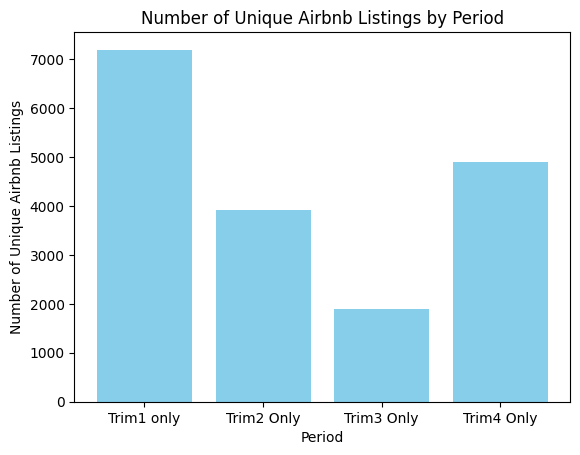

In [ ]:


periods = [ 'Trim1 only', 'Trim2 Only' ,'Trim3 Only','Trim4 Only']
unique_counts = [len(unique_T1) ,len(unique_T2) , len(unique_T3),len(unique_T4) ]

plt.bar(periods, unique_counts, color='skyblue')
plt.xlabel('Period')
plt.ylabel('Number of Unique Airbnb Listings')
plt.title('Number of Unique Airbnb Listings by Period')
plt.show()

In [24]:
# Calculer les intersections entre les périodes
common_Trim4_Trim1 = set_T4 & set_T1
common_Trim4_Trim3 = set_T4 & set_T3
common_Trim4_Trim2 = set_T4 & set_T2


common_table_trim4andOthers = {
    'Trim4 & Trim1': len(common_Trim4_Trim1),
    'Trim4 & Trim2': len(common_Trim4_Trim2),
    'Trim4 & Trim3': len(common_Trim4_Trim3),
}


print(pd.DataFrame(list(common_table_trim4andOthers.items()), columns=['Period Pair', 'Common Airbnb Count']))

     Period Pair  Common Airbnb Count
0  Trim4 & Trim1                65847
1  Trim4 & Trim2                78092
2  Trim4 & Trim3                85483


In [26]:

all_ids_unique = set_T4.union(set_T3).union(set_T2).union(set_T1)

# Nombre total d'Airbnb uniques
total_airbnb = len(all_ids_unique)


print("Le nombre total annonce d'Airbnb uniques sur les 4 périodes est:", total_airbnb)

Le nombre total annonce d'Airbnb uniques sur les 4 périodes est: 118021


In [27]:
# Filtrer les Airbnb présents sur les 4 périodes (en utilisant les IDs communs)
common_ids = set_T4.intersection(set_T3, set_T2, set_T1)
print("Le nombre d'Airbnb présents sur les 4 périodes est:", len(common_ids))

Le nombre d'Airbnb présents sur les 4 périodes est: 65003


In [28]:
common_ids_df = spark.createDataFrame([(i,) for i in common_ids], ["id"])

# Filtrage des DataFrames originaux avec les ids communs
df_T1_filtered = df_listingT1.join(common_ids_df, on="id", how="inner")
df_T2_filtered = df_listingT2.join(common_ids_df, on="id", how="inner")
df_T3_filtered = df_listingT3.join(common_ids_df, on="id", how="inner")
df_T4_filtered = df_listingT4.join(common_ids_df, on="id", how="inner")

In [ ]:
df_T1_filteredbis = df_T1_filtered.select(*[col(c).alias(f"{c}_T1") if c != 'id' else col(c) for c in df_T1_filtered.columns])
df_T1_filteredbis.show(5)

+-------+---------+--------------------+----------+------------+----------------------+-----------------+-----------+------------+---------------+--------+-----------------+--------------------+--------------+--------------------+---------------------------------+-------------------+------------------------+-------------+------------+
|     id|row_id_T1|             name_T1|host_id_T1|host_name_T1|neighbourhood_group_T1| neighbourhood_T1|latitude_T1|longitude_T1|   room_type_T1|price_T1|minimum_nights_T1|number_of_reviews_T1|last_review_T1|reviews_per_month_T1|calculated_host_listings_count_T1|availability_365_T1|number_of_reviews_ltm_T1|   license_T1|trimestre_T1|
+-------+---------+--------------------+----------+------------+----------------------+-----------------+-----------+------------+---------------+--------+-----------------+--------------------+--------------+--------------------+---------------------------------+-------------------+------------------------+-------------+---

In [31]:
df_T1_filteredbis.count()

65003

In [34]:

df_T1_price = df_T1_filtered.select(
    col("id"),
    col("price").alias("price_T1")
)

df_T2_price = df_T2_filtered.select(
    col("id"),
    col("price").alias("price_T2")
)

df_T3_price = df_T3_filtered.select(
    col("id"),
    col("price").alias("price_T3")
)

df_T4_price = df_T4_filtered.select(
    col("id"),
    col("price").alias("price_T4")
)


merged_df = df_T1_price.join(df_T2_price, on="id", how="inner")
merged_df = merged_df.join(df_T3_price, on="id", how="inner")
merged_df = merged_df.join(df_T4_price, on="id", how="inner")
merged_df.show(5)

+-----+--------+--------+--------+--------+
|   id|price_T1|price_T2|price_T3|price_T4|
+-----+--------+--------+--------+--------+
| 5396|  107.00|   96.00|   95.00|   88.00|
| 9952|  130.00|  169.00|  246.00|  150.00|
|11798|  127.00|  119.00|  124.00|  120.00|
|17316|    0.00|    0.00|    0.00|    0.00|
|19029|   45.00|   52.00|   67.00|   59.00|
+-----+--------+--------+--------+--------+
only showing top 5 rows



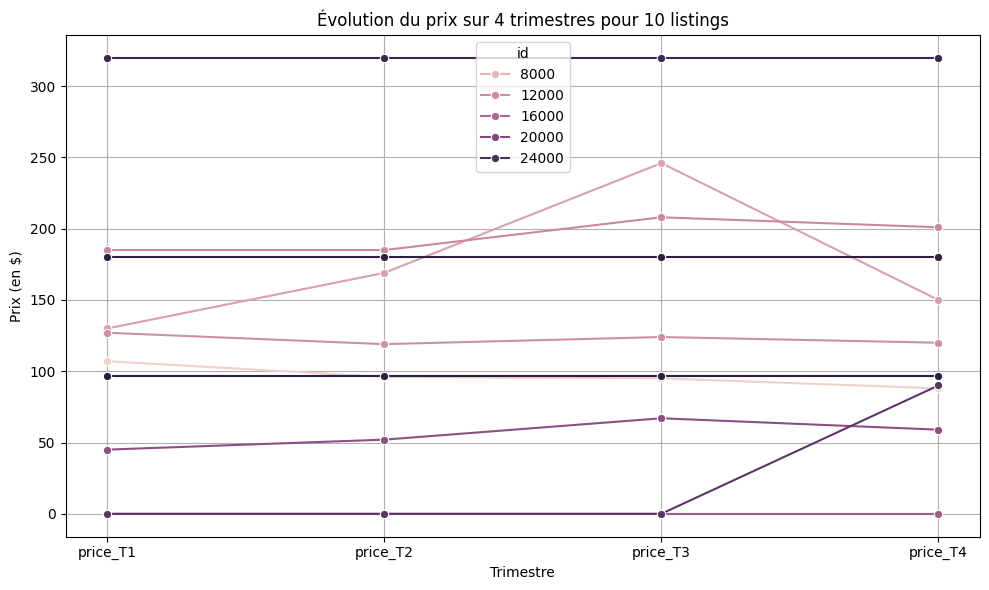

In [37]:
ids_sample = merged_df.select("id").limit(10).toPandas()["id"].tolist()

merged_df_filtered = merged_df.filter(merged_df["id"].isin(ids_sample))

pdf = merged_df_filtered.toPandas()

pdf_melted = pd.melt(
    pdf,
    id_vars=["id"],
    value_vars=["price_T1", "price_T2", "price_T3", "price_T4"],
    var_name="Trimestre",
    value_name="Prix"
)


plt.figure(figsize=(10, 6))
sns.lineplot(data=pdf_melted, x="Trimestre", y="Prix", hue="id", marker="o")
plt.title("Évolution du prix sur 4 trimestres pour 10 listings")
plt.ylabel("Prix (en $)")
plt.xlabel("Trimestre")
plt.grid(True)
plt.tight_layout()
plt.show()


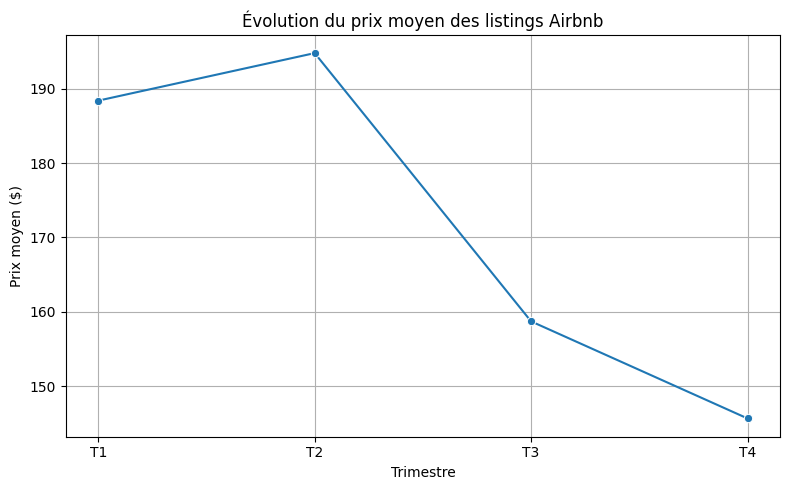

In [38]:
# Calcul des prix moyen de chaque trimestre
mean_T1 = merged_df.selectExpr("avg(price_T1) as mean_T1").toPandas()["mean_T1"][0]
mean_T2 = merged_df.selectExpr("avg(price_T2) as mean_T2").toPandas()["mean_T2"][0]
mean_T3 = merged_df.selectExpr("avg(price_T3) as mean_T3").toPandas()["mean_T3"][0]
mean_T4 = merged_df.selectExpr("avg(price_T4) as mean_T4").toPandas()["mean_T4"][0]




df_mean_price = pd.DataFrame({
    "Trimestre": ["T1", "T2", "T3", "T4"],
    "Prix Moyen": [mean_T1, mean_T2, mean_T3, mean_T4]
})


plt.figure(figsize=(8, 5))
sns.lineplot(data=df_mean_price, x="Trimestre", y="Prix Moyen", marker="o")
plt.title("Évolution du prix moyen des listings Airbnb")
plt.xlabel("Trimestre")
plt.ylabel("Prix moyen ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
from pyspark.sql.functions import col, avg, stddev, min, max, expr, percentile_approx

def compute_stats(df, suffix):
    stats = df.select(
        avg(f"price_{suffix}").alias("mean"),
        expr(f"percentile_approx(price_{suffix}, 0.5)").alias("median"),
        stddev(f"price_{suffix}").alias("stddev"),
        min(f"price_{suffix}").alias("min"),
        max(f"price_{suffix}").alias("max")
    ).toPandas().iloc[0]
    stats["Trimestre"] = suffix
    return stats


stats_T1 = compute_stats(merged_df, "T1")
stats_T2 = compute_stats(merged_df, "T2")
stats_T3 = compute_stats(merged_df, "T3")
stats_T4 = compute_stats(merged_df, "T4")

df_stats = pd.DataFrame([stats_T1, stats_T2, stats_T3, stats_T4])

df_stats = df_stats[["Trimestre", "mean", "median", "stddev", "min", "max"]]
df_stats = df_stats.sort_values("Trimestre")

df_stats = df_stats.round(2)


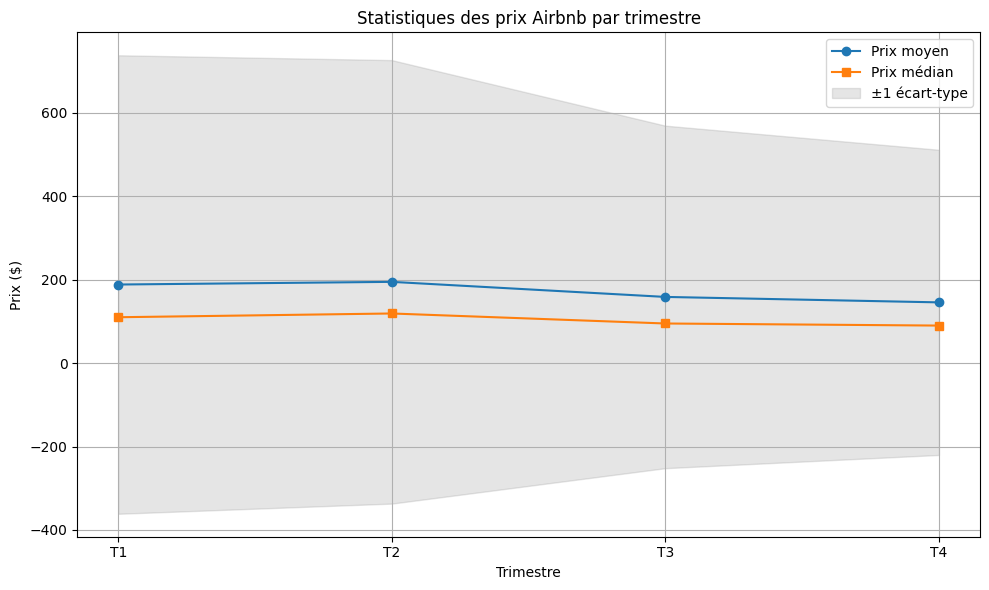

In [44]:

plt.figure(figsize=(10, 6))


plt.plot(df_stats["Trimestre"], df_stats["mean"], marker='o', label='Prix moyen')
plt.plot(df_stats["Trimestre"], df_stats["median"], marker='s', label='Prix médian')

# Bande pour l'écart-type
plt.fill_between(df_stats["Trimestre"],
                 df_stats["mean"].astype(float) - df_stats["stddev"].astype(float),
                 df_stats["mean"].astype(float) + df_stats["stddev"].astype(float),
                 color='gray', alpha=0.2, label='±1 écart-type')

# Finitions
plt.title("Statistiques des prix Airbnb par trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Prix ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


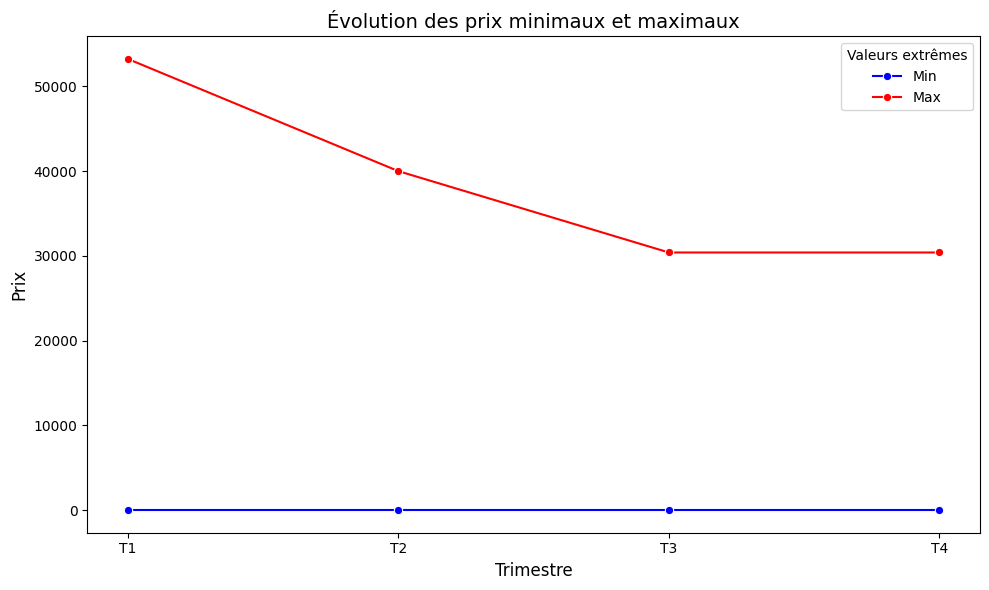

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=df_stats, x="Trimestre", y="min", label="Min", marker="o", ax=ax, color="blue")
sns.lineplot(data=df_stats, x="Trimestre", y="max", label="Max", marker="o", ax=ax, color="red")

ax.set_title('Évolution des prix minimaux et maximaux', fontsize=14)
ax.set_xlabel('Trimestre', fontsize=12)
ax.set_ylabel('Prix', fontsize=12)
ax.legend(title="Valeurs extrêmes")

plt.tight_layout()
plt.show()


In [67]:
df_T1_filtered = df_T1_filtered.withColumnRenamed("price", "price_T1")
df_T2_filtered = df_T2_filtered.withColumnRenamed("price", "price_T2")
df_T3_filtered = df_T3_filtered.withColumnRenamed("price", "price_T3")
df_T4_filtered = df_T4_filtered.withColumnRenamed("price", "price_T4")

merged_df = df_T4_filtered.join(df_T1_filtered, on="id", how="inner") \
                          .join(df_T2_filtered, on="id", how="inner") \
                          .join(df_T3_filtered, on="id", how="inner")
                        
merged_df.show(5)

+-----+------+--------------------+-------+---------+-------------------+---------------+---------+---------+---------------+--------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------+---------+------+--------------------+-------+---------+-------------------+---------------+---------+---------+---------------+--------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------+---------+------+--------------------+-------+---------+-------------------+---------------+---------+---------+---------------+--------+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------------+---------+------+--------------------+-------+---------+-------------------+---------------+---------+---------+---------------+--------+--------------

In [68]:
merged_df = merged_df.withColumn("variation_T1_T2", F.col("price_T2") - F.col("price_T1")) \
                     .withColumn("variation_T2_T3", F.col("price_T3") - F.col("price_T2")) \
                     .withColumn("variation_T3_T4", F.col("price_T4") - F.col("price_T3"))


merged_df.select("id", "price_T1", "price_T2", "price_T3", "price_T4",
                 "variation_T1_T2", "variation_T2_T3", "variation_T3_T4").show()

# Statistiques descriptives
merged_df.select("variation_T1_T2", "variation_T2_T3", "variation_T3_T4").describe().show()

+-----+--------+--------+--------+--------+---------------+---------------+---------------+
|   id|price_T1|price_T2|price_T3|price_T4|variation_T1_T2|variation_T2_T3|variation_T3_T4|
+-----+--------+--------+--------+--------+---------------+---------------+---------------+
| 5396|  107.00|   96.00|   95.00|   88.00|         -11.00|          -1.00|          -7.00|
| 9952|  130.00|  169.00|  246.00|  150.00|          39.00|          77.00|         -96.00|
|11798|  127.00|  119.00|  124.00|  120.00|          -8.00|           5.00|          -4.00|
|17316|    0.00|    0.00|    0.00|    0.00|           0.00|           0.00|           0.00|
|19029|   45.00|   52.00|   67.00|   59.00|           7.00|          15.00|          -8.00|
|22979|    0.00|    0.00|    0.00|   90.00|           0.00|           0.00|          90.00|
|26827|   97.00|   97.00|   97.00|   97.00|           0.00|           0.00|           0.00|
|36724|   93.00|   90.00|    0.00|    0.00|          -3.00|         -90.00|     

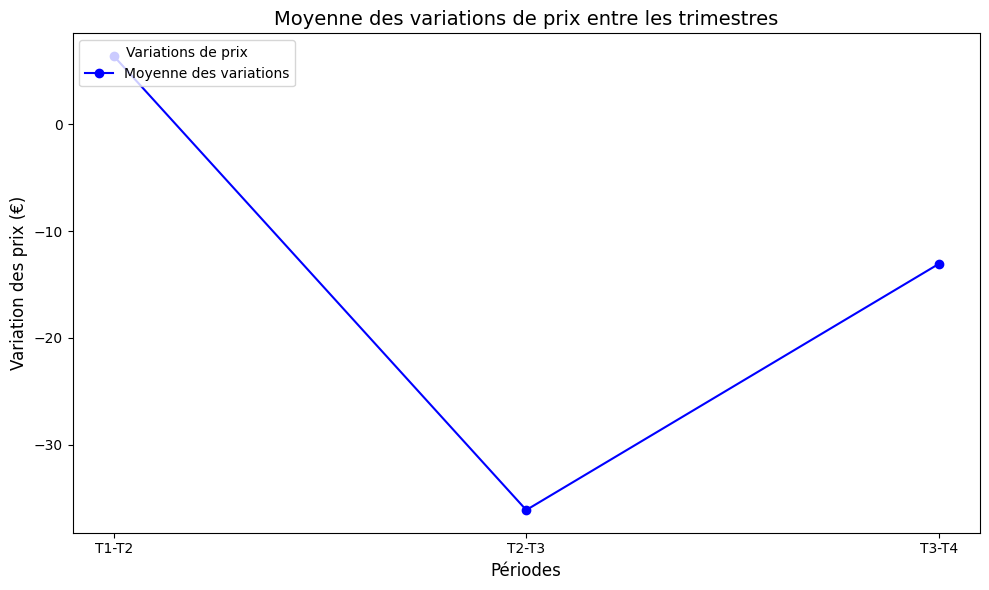

In [70]:
import matplotlib.pyplot as plt
import numpy as np

mean_variations = [
    merged_df.select("variation_T1_T2").agg({"variation_T1_T2": "avg"}).collect()[0][0],
    merged_df.select("variation_T2_T3").agg({"variation_T2_T3": "avg"}).collect()[0][0],
    merged_df.select("variation_T3_T4").agg({"variation_T3_T4": "avg"}).collect()[0][0]
]

trimestres = ['T1-T2', 'T2-T3', 'T3-T4']

plt.figure(figsize=(10, 6))
plt.plot(trimestres, mean_variations, marker='o', label='Moyenne des variations', color='blue')

plt.title('Moyenne des variations de prix entre les trimestres', fontsize=14)
plt.xlabel('Périodes', fontsize=12)
plt.ylabel('Variation des prix (€)', fontsize=12)
plt.legend(title="Variations de prix", loc="upper left")

plt.tight_layout()
plt.show()
